In [349]:
import os
import molgrid
import pytest
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
import matplotlib.pyplot as plt

# Misc
from tqdm import tqdm

%matplotlib inline

In [350]:
torch.cuda.is_available()

True

In [351]:
class Net(nn.Module):
        def __init__(self, dims):
            super(Net, self).__init__()
            self.pool0 = nn.MaxPool3d(2)
            self.conv1 = nn.Conv3d(dims[0], 32, kernel_size=3, padding=1)
            self.pool1 = nn.MaxPool3d(2)
            self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
            self.pool2 = nn.MaxPool3d(2)
            self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)

            self.last_layer_size = dims[1]//8 * dims[2]//8 * dims[3]//8 * 128
            print( self.last_layer_size, 'here it is  self.last_layer_size')
            self.fc1 = nn.Linear(self.last_layer_size, 2)

        def forward(self, x):
            x = self.pool0(x)
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            x = F.relu(self.conv3(x))
            x = x.view(-1, self.last_layer_size)
            x = self.fc1(x)
            return x

In [352]:
def weights_init(m):
        if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight.data)

In [353]:
def test_train_torch_cnn(epochs):
    batch_size = 50
    datadir = os.getcwd() +'/_data'
    fname = datadir+"/small-mol.types"
    files = "/demo"
    
    molgrid.set_random_seed(0)
    torch.manual_seed(0)
    np.random.seed(0)

    batch_size = 50
    e = molgrid.ExampleProvider(data_root=datadir+files,balanced=True,shuffle=True)
    e.populate(fname)

    gmaker = molgrid.GridMaker()
    dims = gmaker.grid_dimensions(e.num_types())
    tensor_shape = (batch_size,)+dims
    print(tensor_shape)
    model = Net(dims).to('cuda')
    model.apply(weights_init)

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    input_tensor = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
    float_labels = torch.zeros(batch_size, dtype=torch.float32)

    losses = []
    for iteration in tqdm(range(epochs)):

        batch = e.next_batch(batch_size)
        gmaker.forward(batch, input_tensor, 0, random_rotation=False) #not rotating since convergence is faster this way
        batch.extract_label(0, float_labels)
        labels = float_labels.long().to('cuda')

        optimizer.zero_grad()
        output = model(input_tensor)
        loss = F.cross_entropy(output,labels)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
    plt.plot(losses)
    return model, losses

(50, 28, 48, 48, 48)
27648 here it is  self.last_layer_size


  0%|          | 0/500 [00:00<?, ?it/s]==============================
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/ggraeff/workspace/Docking-Input/tutoriais/_data/demo/4kzu/4kzu_protein.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/ggraeff/workspace/Docking-Input/tutoriais/_data/demo/3kr8/3kr8_protein.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/ggraeff/workspace/Docking-Input/tutoriais/_data/demo/3dd0/3dd0_protein.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /home/ggraeff/workspace/Docking-Input/tutoriais/_data/demo/1p1q/1p1q_protein.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (ti

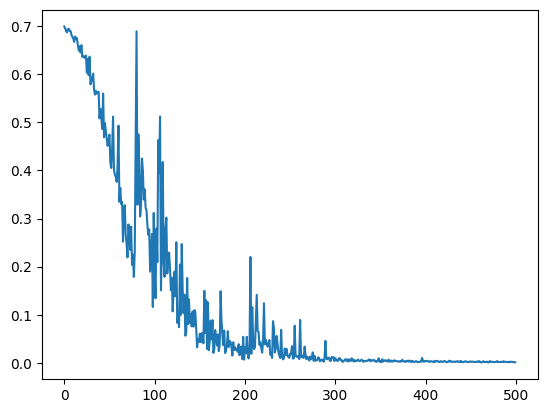

In [354]:
model, losses = test_train_torch_cnn(epochs = 500)

In [355]:
model

Net(
  (pool0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv3d(28, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=27648, out_features=2, bias=True)
)

In [356]:
losses[:5]

[0.6992685794830322,
 0.6951993703842163,
 0.6897801756858826,
 0.6870943307876587,
 0.6934351325035095]